# CNN Calibration Quicktest

In [145]:
%load_ext autoreload
%autoreload 2

import json
import pathlib
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import torch

from torch.utils.data import DataLoader

sys.path.append('/mnt/home/achoudhri/gerbilizer/training')

from dataloaders import GerbilVocalizationDataset
from models import build_model
from train import Trainer
from calibration import calibration_step, calibration_from_steps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
MODEL_PATH = pathlib.Path('/mnt/home/atanelus/Heap/gerbilizer/trained_models/alex/00001')

with open(MODEL_PATH / 'config.json', 'r') as f:
    config = json.load(f)

config['WEIGHTS_PATH'] = str(MODEL_PATH / 'best_weights.pt')

model = Trainer.from_trained_model(config)

In [147]:
arena_dims = (config['ARENA_WIDTH'], config['ARENA_LENGTH'])
make_xcorr = config['COMPUTE_XCORRS']
test_file = '/mnt/home/atanelus/ceph/iteration/small_room_4/test_set.h5'
test_set = GerbilVocalizationDataset(test_file, segment_len=config['SAMPLE_LEN'], arena_dims=arena_dims, make_xcorrs=make_xcorr)
test_set.samp_size = 30  # take 30 samples from each vocalization. Pass them to the model as if each were a full batch of inputs
#test_set_loader = DataLoader(test_set, args.config_data['TEST_BATCH_SIZE'], shuffle=False)
test_set_loader = DataLoader(test_set, 1, shuffle=False)  # Only using Dataloader here for the convenience of converting np.ndarray to torch.Tensor

In [148]:
len(test_set)

2000

In [149]:
# import cProfile

# def wrapper():
#     bin_idxs = calibration_step(
#         centimeter_output,
#         centimeter_location,
#         arena_dims,
#         sigma_values
#     )

# cProfile.run('wrapper()')

In [150]:
class LimitedLoader():
    def __init__(self, dataloader, i):
        self.dataloader = dataloader
        self.i = i
    
    def __len__(self):
        return self.i
    
    def __iter__(self):
        self.count = 0
        self.iterloader = iter(self.dataloader)
        return self
    
    def __next__(self):
        if self.count >= len(self):
            raise StopIteration
        self.count += 1
        return next(self.iterloader)

In [164]:
def wrapper():
    start = time.time()
    device = 'gpu' if torch.cuda.is_available() else 'cpu'

    dest_path = pathlib.Path.home() / 'ceph' / 'tmp.h5'

    with h5py.File(dest_path, 'w') as dest:
        with h5py.File(test_file, 'r') as source:
            if 'len_idx' in source:
                n_vox = len(source['len_idx']) - 1
            else:
                n_vox = source['vocalizations'].shape[0]

            source.copy(source['locations'], dest['/'], 'locations')

        preds = dest.create_dataset(
            'predictions',
            shape=(n_vox, 2),
            dtype=np.float32
        )
        vars = dest.create_dataset(
            'std',
            shape=(n_vox,),
            dtype=np.float32
        )

        sigma_values = np.linspace(1e-4, 50, 20)
        model.model.eval()

        mass_counts = np.zeros((len(sigma_values), 10))

        # pool = mp.Pool()


        with torch.no_grad():
            for idx, (audio, location) in enumerate(small_loader):
                audio = audio.squeeze()
                if device == 'gpu':
                    audio = audio.cuda()
                # output = model.model(audio)
                output = model.model(audio)
                # output = output.mean(dim=0, keepdims=True)  # Output should have shape (30, 2)
                centimeter_output = GerbilVocalizationDataset.unscale_features(
                    output.cpu().numpy(), arena_dims=arena_dims
                    )
                centimeter_location = GerbilVocalizationDataset.unscale_features(
                    location.cpu().numpy(), arena_dims=arena_dims
                    )

                def update_mass_counts(bin_idxs):
                    for sigma_i, bin_idx in enumerate(bin_idxs):
                        mass_counts[sigma_i][bin_idx] += 1
                
                update_mass_counts(
                    calibration_step(
                        centimeter_output,
                        centimeter_location,
                        arena_dims,
                        sigma_values,
                        grid_resolution = 0.75,
                    )
                )
                # pool.apply_async(
                #     calibration_step,
                #     (
                #         centimeter_output,
                #         centimeter_location,
                #         arena_dims,
                #         sigma_values
                #     ),
                #     callback = update_mass_counts
                #  )

                centroid = centimeter_output.mean(axis=0)
                distances = np.sqrt( ((centroid[None, ...] - centimeter_output)**2).sum(axis=-1) )  # Should have shape (30,)
                dist_spread = distances.std()
                # preds[idx:idx+n_added] = centimeter_output
                preds[idx] = centroid
                vars[idx] = dist_spread

        # pool.close()
        # # wait for each process to exit
        # pool.join()

        # calculate calibration
        curves, abs_errs, signed_errs = calibration_from_steps(mass_counts)
        print(mass_counts)
        # print(curves)


        cal_grp = dest.create_group('calibration')
        calibration_curves = cal_grp.create_dataset(
            'curves',
            data=curves
        )

        abs_err_dataset = cal_grp.create_dataset(
            'abs_errs',
            data=abs_errs
        )

        signed_err_dataset = cal_grp.create_dataset(
            'signed_errs',
            data=signed_errs
        )

    end = time.time()


    print(f'Total time elapsed: {end - start:.4f} s | Approximate time per sample: {(end - start) / len(small_loader) : 0.4f}')

In [165]:
import cProfile

cProfile.run('wrapper()')

         479 function calls (464 primitive calls) in 0.016 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.016    0.016 3025756294.py:1(wrapper)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1017(_handle_fromlist)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:389(parent)
        1    0.000    0.000    0.016    0.016 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 __init__.py:77(is_available)
        5    0.000    0.000    0.000    0.000 base.py:305(id)
        1    0.000    0.000    0.000    0.000 base.py:338(__init__)
        2    0.000    0.000    0.000    0.000 compat.py:11(filename_encode)
        2    0.000    0.000    0.000    0.000 enum.py:313(__call__)
        2    0.000    0.000    0.000    0.000 enum.py:631(__new__)
        1    0.000    0.000    0.000    0.000 enum.py:938(__and__)
        2    0.000    

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/mnt/home/atanelus/ceph/iteration/small_room_4/test_set.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [161]:
small_loader = LimitedLoader(test_set_loader, 50)

In [92]:
import multiprocessing as mp
import time

start = time.time()
device = 'gpu' if torch.cuda.is_available() else 'cpu'

dest_path = pathlib.Path.home() / 'ceph' / 'tmp.h5'

with h5py.File(dest_path, 'w') as dest:
    with h5py.File(test_file, 'r') as source:
        if 'len_idx' in source:
            n_vox = len(source['len_idx']) - 1
        else:
            n_vox = source['vocalizations'].shape[0]

        source.copy(source['locations'], dest['/'], 'locations')
            
    preds = dest.create_dataset(
        'predictions',
        shape=(n_vox, 2),
        dtype=np.float32
    )
    vars = dest.create_dataset(
        'std',
        shape=(n_vox,),
        dtype=np.float32
    )
    
    sigma_values = np.linspace(1e-4, 50, 50)
    model.model.eval()

    mass_counts = np.zeros((len(sigma_values), 10))
    
    pool = mp.Pool()
    
    
    with torch.no_grad():
        for idx, (audio, location) in enumerate(small_loader):
            audio = audio.squeeze()
            if device == 'gpu':
                audio = audio.cuda()
            # output = model.model(audio)
            output = model.model(audio)
            # output = output.mean(dim=0, keepdims=True)  # Output should have shape (30, 2)
            centimeter_output = GerbilVocalizationDataset.unscale_features(
                output.cpu().numpy(), arena_dims=arena_dims
                )
            centimeter_location = GerbilVocalizationDataset.unscale_features(
                location.cpu().numpy(), arena_dims=arena_dims
                )
            
            def update_mass_counts(bin_idxs):
                for sigma_i, bin_idx in enumerate(bin_idxs):
                    mass_counts[sigma_i][bin_idx] += 1
                
            pool.apply_async(
                calibration_step,
                (
                    centimeter_output,
                    centimeter_location,
                    arena_dims,
                    sigma_values
                ),
                callback = update_mass_counts
             )
            
            centroid = centimeter_output.mean(axis=0)
            distances = np.sqrt( ((centroid[None, ...] - centimeter_output)**2).sum(axis=-1) )  # Should have shape (30,)
            dist_spread = distances.std()
            # preds[idx:idx+n_added] = centimeter_output
            preds[idx] = centroid
            vars[idx] = dist_spread
    
    pool.close()
    # wait for each process to exit
    pool.join()
    
    # calculate calibration
    curves, abs_errs, signed_errs = calibration_from_steps(mass_counts)        


    cal_grp = dest.create_group('calibration')
    calibration_curves = cal_grp.create_dataset(
        'curves',
        data=curves
    )

    abs_err_dataset = cal_grp.create_dataset(
        'abs_errs',
        data=abs_errs
    )

    signed_err_dataset = cal_grp.create_dataset(
        'signed_errs',
        data=signed_errs
    )

end = time.time()

print(f'Total time elapsed: {end - start:.4f} s | Approximate time per sample: {(end - start) / len(small_loader) : 0.4f}')

Total time elapsed: 354.6623 s | Approximate time per sample:  3.5466


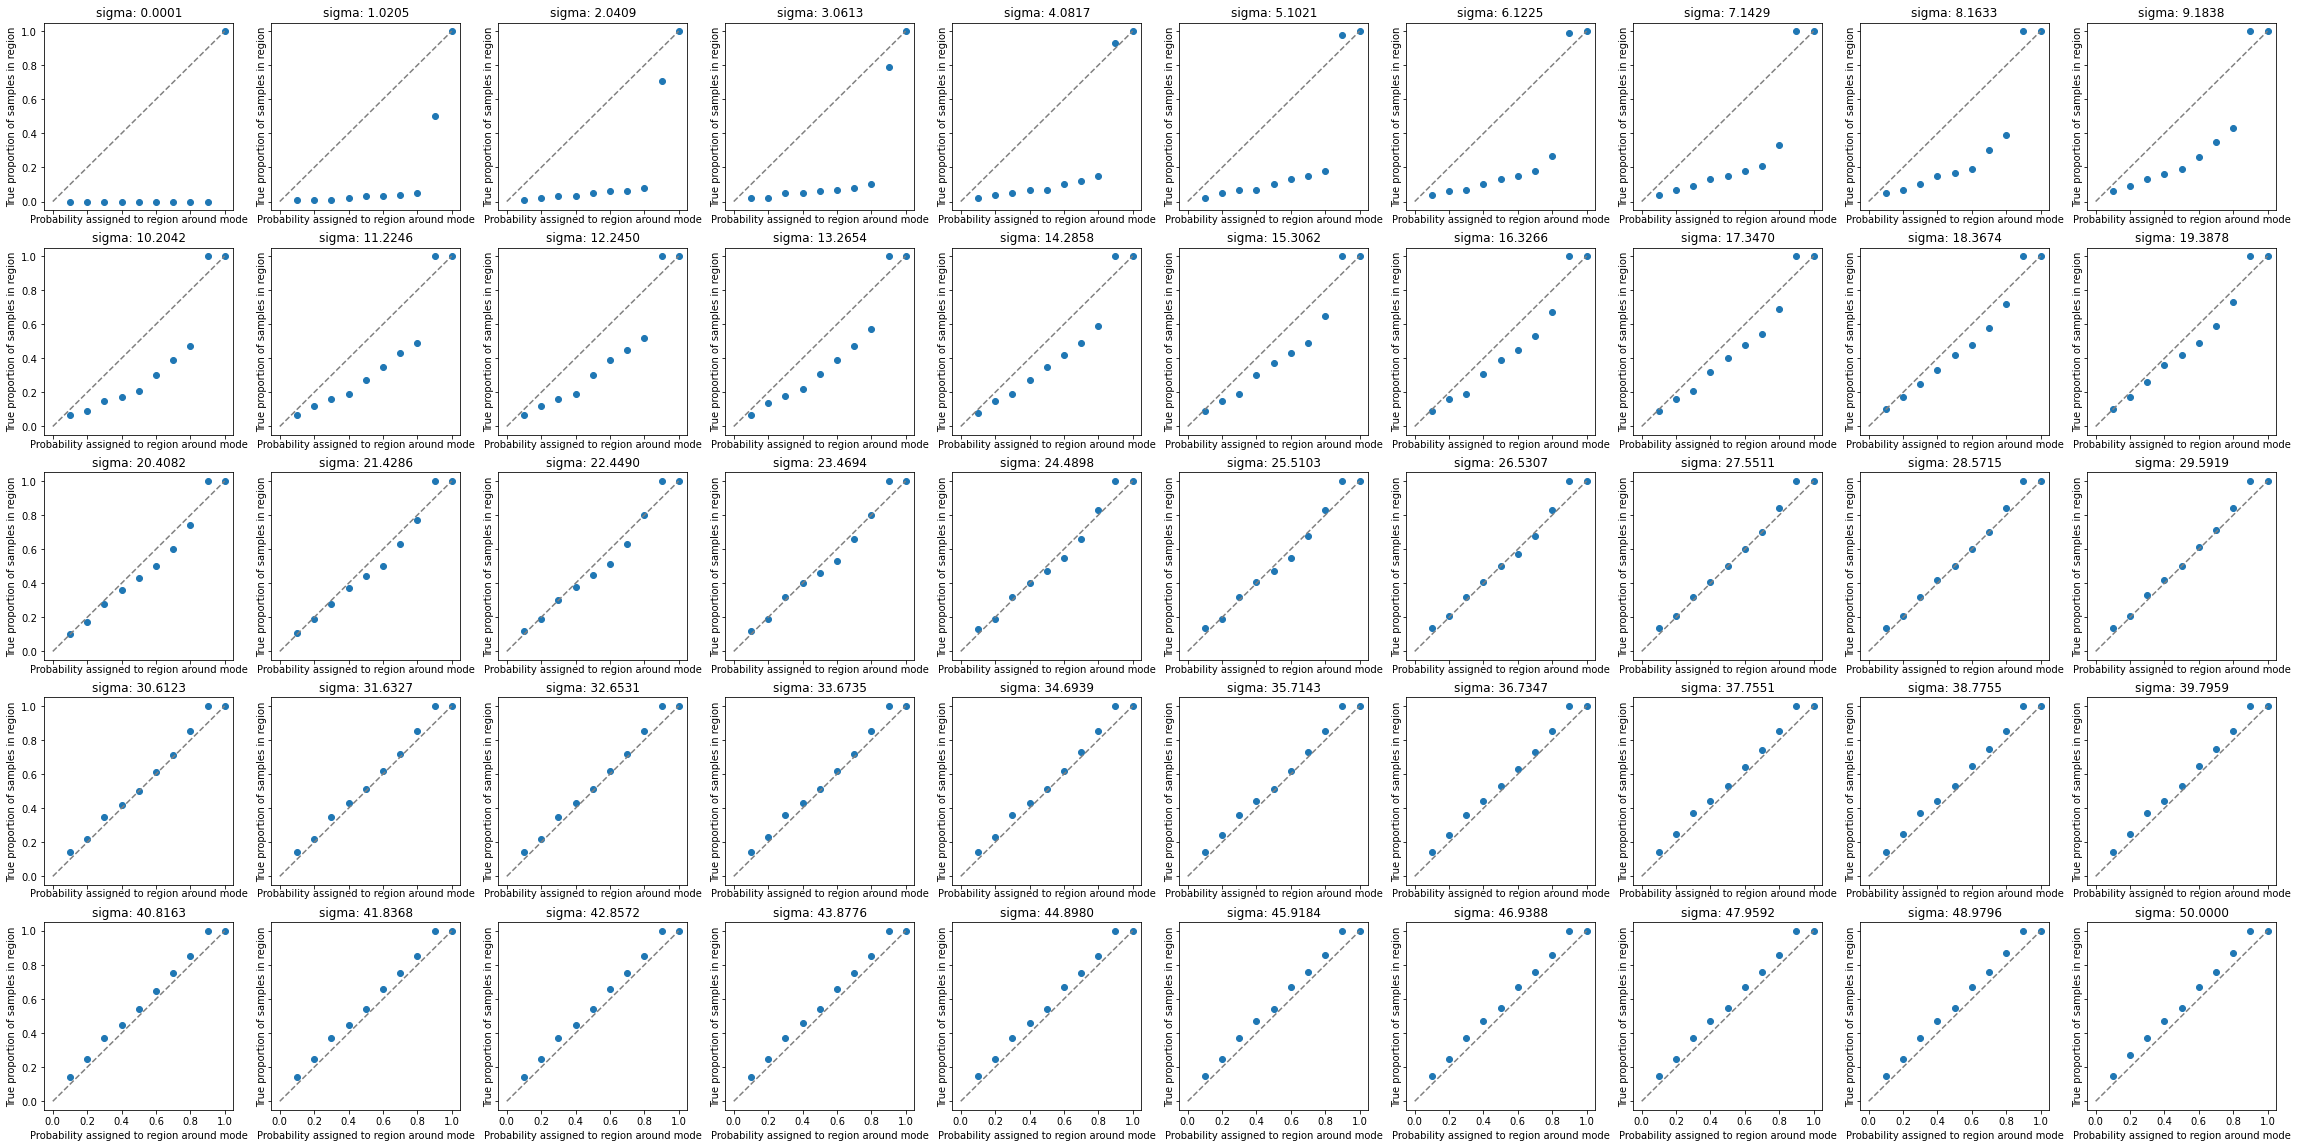

In [93]:
from common import plotting

bin_edges = np.linspace(0, 1, 11)[1:]
fig, axs = plotting.subplots(curves.shape[0])
for ax, curve, sigma in zip(axs, curves, sigma_values):
    plotting.plot_calibration_curve(bin_edges, curve, ax)
    ax.set_title(f'sigma: {sigma:0.4f}')

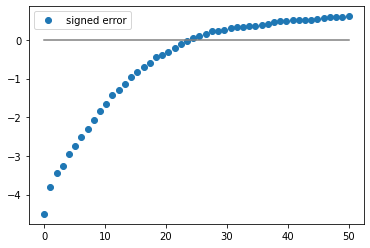

In [128]:
fig, ax = plt.subplots()

# ax.plot(sigma_values, abs_errs, label='absolute error', marker='o', linestyle="None")
ax.plot(sigma_values, signed_errs, label='signed error', marker='o', linestyle="None")
ax.plot([0, 50], [0, 0], color='grey')
plt.legend()
plt.show()

In [172]:
with h5py.File(dest_path, 'r') as f:
    print(f.attrs.keys())

<KeysViewHDF5 []>


In [96]:
sigma_values[abs_errs.argmin()]

27.551065306122446

In [99]:
arena_dims_cm = np.array(arena_dims) / 10
arena_dims_cm

array([60., 40.])

In [100]:
sample_output = centimeter_output + (arena_dims_cm / 2)

In [101]:
get_coords = lambda dim_cm: np.linspace(0, dim_cm, int(dim_cm / 0.1))

xs, ys = map(get_coords, arena_dims_cm)
xgrid, ygrid = np.meshgrid(xs, ys)
coord_grid = np.dstack((xgrid, ygrid))

In [103]:
pmfs = np.zeros((len(sigma_values), *xgrid.shape))

for i, sigma in enumerate(sigma_values):
    for loc_estimate in sample_output:
        # place a spherical gaussian with variance sigma
        # at the individual location estimate
        distr = scipy.stats.multivariate_normal(
            mean=loc_estimate,
            cov= (sigma ** 2)
        )
        # and add it to the corresponding entry in pmfs
        pmfs[i] += distr.pdf(coord_grid)

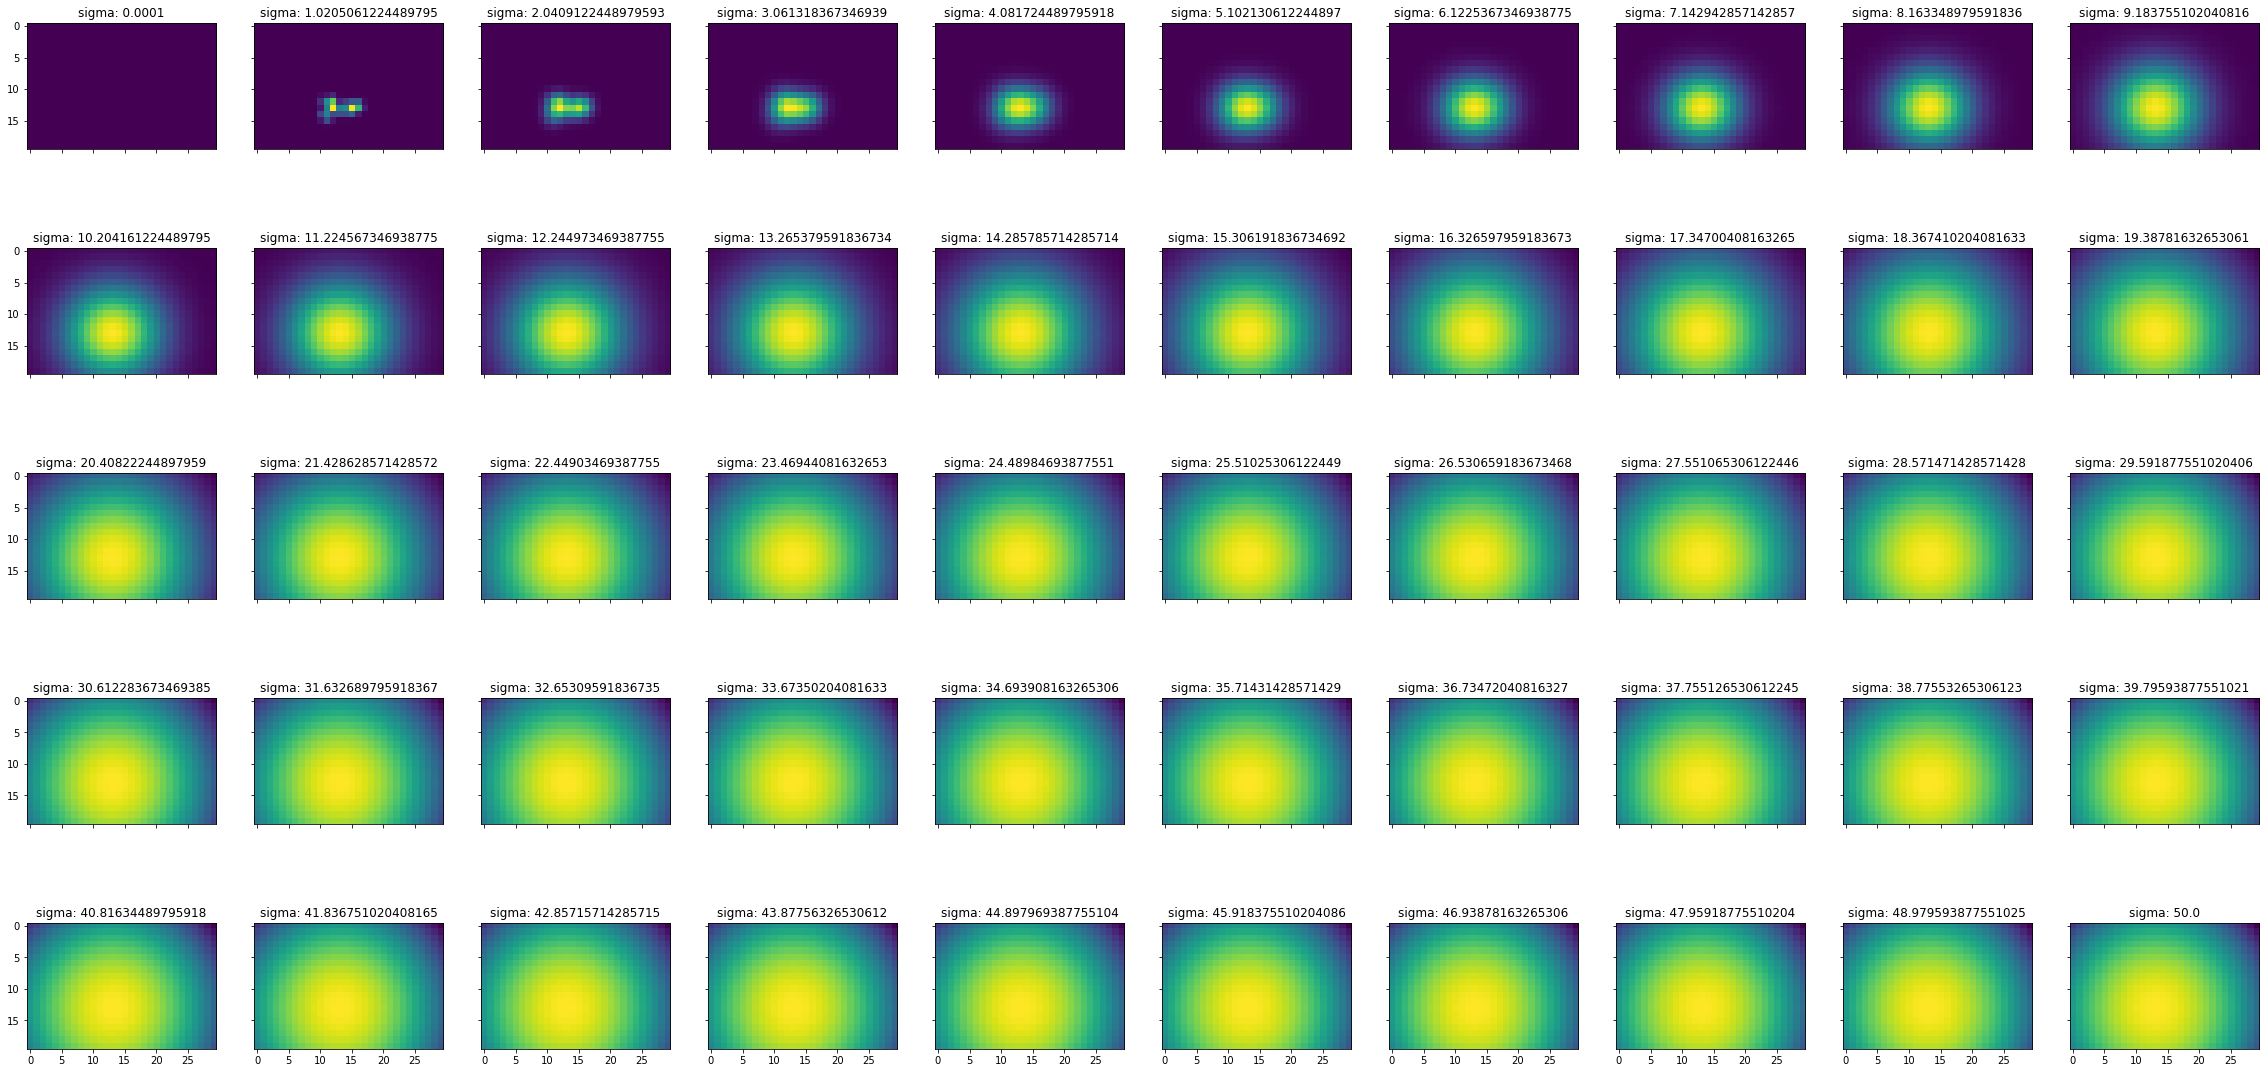

In [144]:
fig, axs = plotting.subplots(pmfs.shape[0])
for i, (ax, pmf) in enumerate(zip(axs, pmfs)):
    ax.imshow(pmf[::20, ::20])
    ax.set_title(f'sigma: {sigma_values[i]}')

In [73]:
1 / (400 * 600)

4.166666666666667e-06

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 1.  ]),
 <AxesSubplot:xlabel='Probability assigned to region around mode', ylabel='True proportion of samples in region'>)

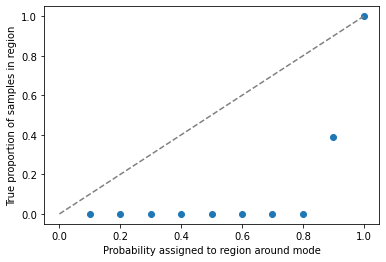

In [38]:
import common.plotting
fig, ax = plt.subplots()
plotting.plot_calibration_curve(bin_edges, curves[0], ax)

In [169]:
bin_idxs

array([-9223372036854775808,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0])

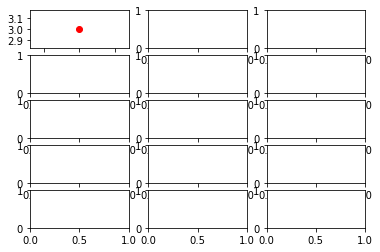

In [134]:
fig, ax = plt.subplots(5, 3)

ax[0][0].plot(*[5, 3], 'ro')

In [89]:
masses

array([6.44703558e-04, 1.08720633e-03, 8.28845285e-04, 7.27073153e-01,
       1.75300465e-03, 5.01403628e-04, 2.88088328e-01, 8.20385829e-04,
       7.25320502e-04, 8.91814954e-04])

In [57]:
arena_dims

(600, 400)

In [14]:
len(test_set_loader)

2000